<a href="https://colab.research.google.com/github/harveyj/aoc/blob/master/6_gpt_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview
- Use pytorch to build a neural net (Transformer-like) that reads in shakespeare.txt and generates more shakespeare
- Character-level language model
- We're generating a decoder only. The encoder is useful for tasks like translation where we are cross-referencing a known input. In this case we are just doing the autoregressive thing which is to look at the current output and generate the plausible next word.

# Network architecture
- After encoding, each token maps to both a token embedding and a positional embedding.
- Pass these variables into a "masked multi-headed attention" layer.
- Masked is ensuring that the values of token N only depends on the values of tokens 0..n-1. In other words, a lower-traiangular matrix.
- The single "attention head" is the key step here.
- - You have a set of inputs. This set of inputs has matrices Q, K, V associated with it. Essentially, you "look up" Q for a given entry against the K for each other entry. Then you multiply by V (TODO: is this the key's V, or the other item's V? I think it's the key's V).
- - Ergo, as the model learns, it learns associations (technical term affinities) between all of the items in the context window.
- - -  For example: assume you have a model where words are tokens. Because you have the token and positions as your input embeddings, you tokenize the sentence "the cat drinks milk", and your attention layer is learnining the correlation between "cat" {position 2} and "milk" {position 4}.
- Multi-headed attention is arranging a layer of many of these attention heads in a layer.
- You then typically have several of these multi-headed attention layers in a sequence.
- Gluing these blocks together you have typical neural net stuff
- - linear layers are at the output of each attention head
- - "add and norm" does two things
- - - "norm" is batch normalization - you almost always want your layer outputs to be unit gaussian, otherwise the math you do ends up blowing up (example, the exponentiation of very large numbers can overflow floats), so this operation maintains the statistical distribution but forces to a unit gaussian
- - - "add" routes input directly to all layers of the network. training deep neural nets is very hard and if you're not careful the early layers compress out a lot of the data, so you route the input to all layers of the net and let the network figure out how much of the input data to value at each layer during training.
- - a softmax layer at the end takes your logits and turns them into a probability distribution


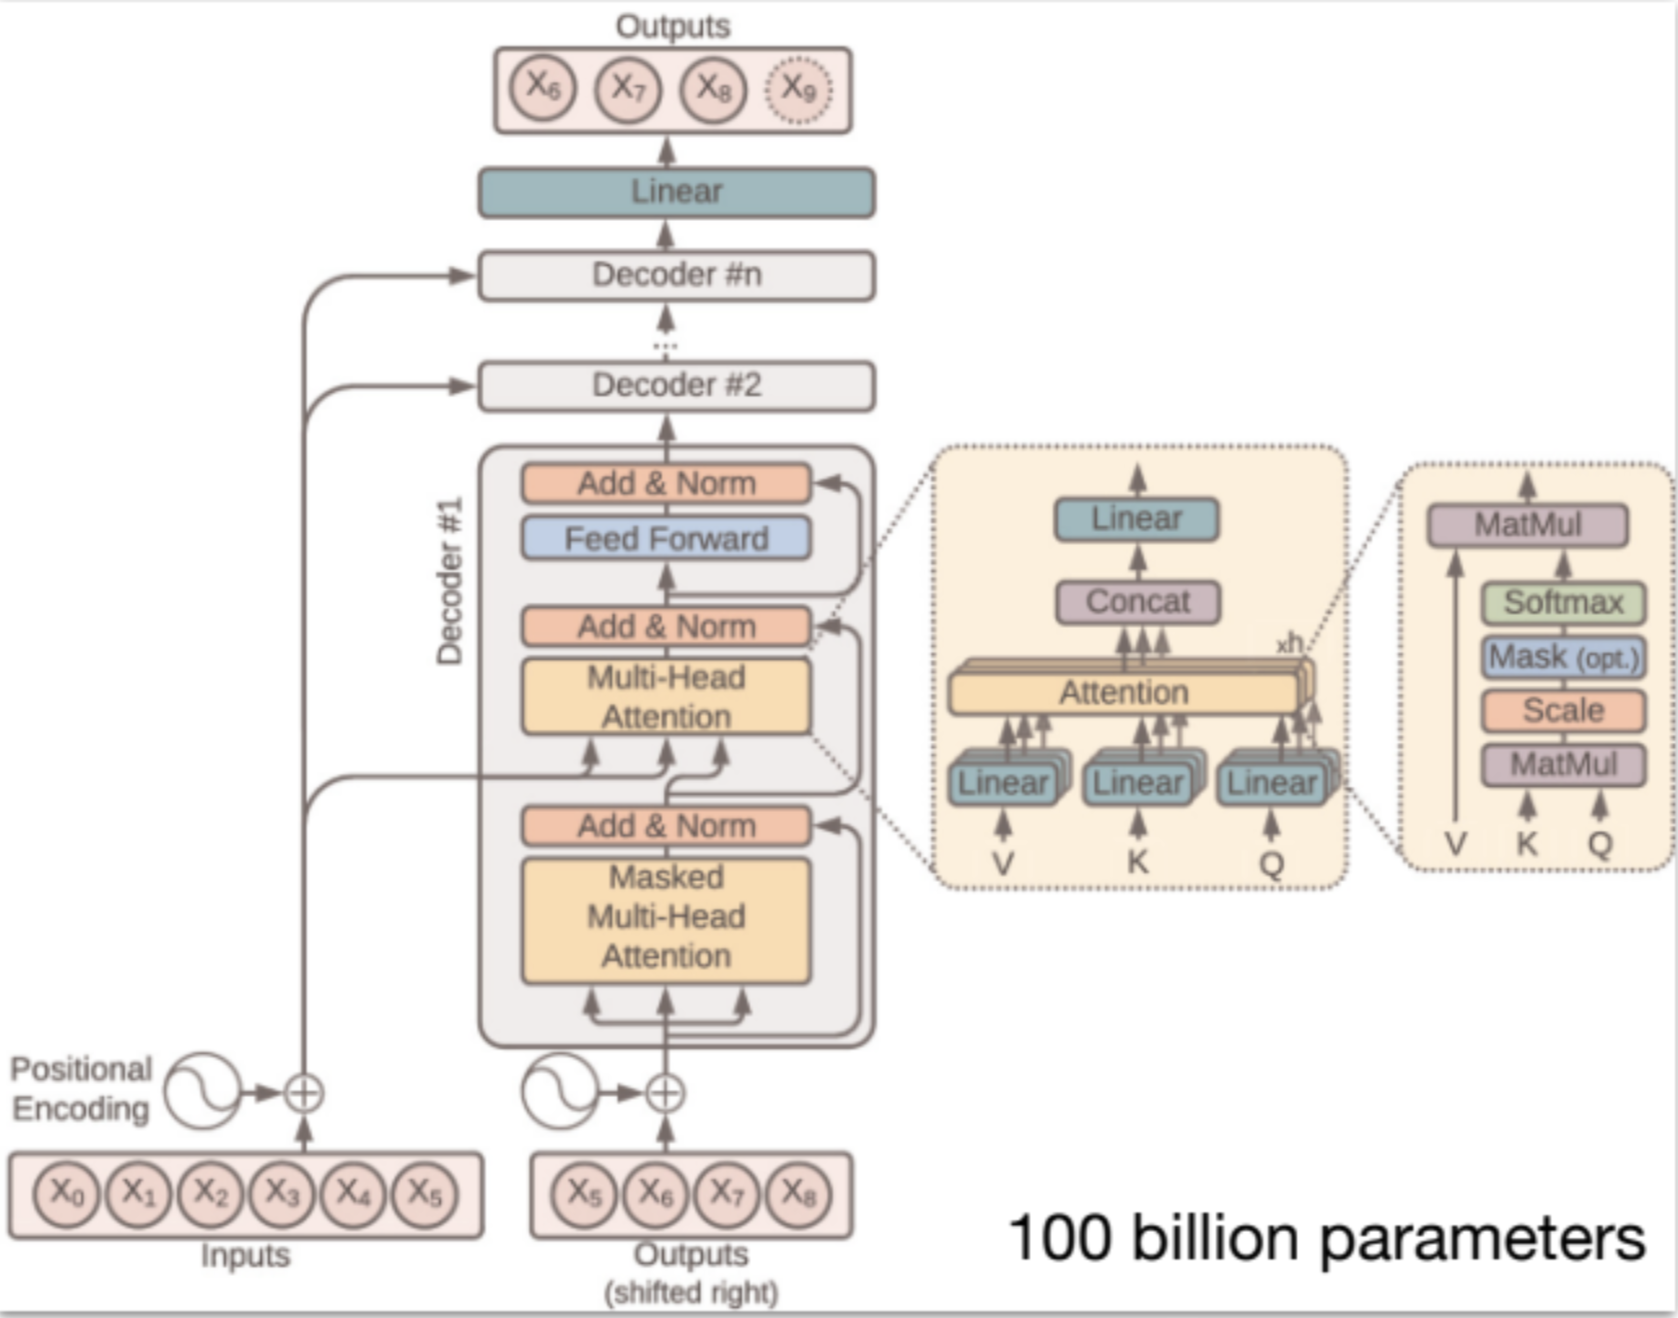

# Recall 2
- Attention: associate a Q, K, V with each input. Calculate Q@K.T @ V for all values.
- Attention semantics: Q is "here's what i want to interact with". K is "here is what should interact with me'. V is "given that this thing interacted with me, here's what I should emit". Ergo, the full matrix multiplication dots each Q against each K and the next matrix multiplication dots the output against V.
- Why masking in the decoder? At inference time, you do not have access to the future elements, they have not been generated yet. Ergo, your training pass should mask out any future elements, otherwise your inference pass will try to pull information from the tokens that have not yet been generated, which is nonsensical.

In [ ]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2024-02-25 14:56:56--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt.1’

input.txt.1         100%[===================>]   1.06M  --.-KB/s    in 0.05s   

2024-02-25 14:56:56 (22.0 MB/s) - ‘input.txt.1’ saved [1115394/1115394]



In [ ]:
with open('input.txt', 'r') as infile:
  raw = infile.read()
chars = list(set(raw))
chars.sort()
vocab_size = len(chars)
itos_map = {i:chars[i] for i in range(len(chars))}
stoi_map = {chars[i]:i for i in range(len(chars))}
itos = lambda l: [itos_map[i] for i in l]
stoi = lambda l: [stoi_map[i] for i in l]
# ''.join(itos(stoi('hello, world!')))


In [ ]:
# --------
# hyperparameters
context_width = 8
# --------


In [ ]:
import random, torch
size = len(raw)
datasets = {"train":raw[:int(size*0.8)],
            "dev": raw[int(size*0.8):int(size*0.9)],
            "test": raw[int(size*0.9):]}

def sample(dataset, n):
  raw = datasets[dataset]; len_raw = len(raw)
  idxs = torch.randint(len_raw-context_width, (n,))
  X = torch.tensor([stoi(raw[idx:idx+context_width]) for idx in idxs])
  Y = torch.tensor([stoi(raw[idx+1:idx+context_width+1]) for idx in idxs])
  return X, Y

def simple_sample(dataset, n):
  raw = datasets[dataset]; len_raw = len(raw)
  idxs = torch.randint(len_raw-context_width, (n,))
  X = torch.tensor([stoi(raw[idx:idx+context_width]) for idx in idxs])
  Y = torch.tensor([stoi(raw[idx+context_width]) for idx in idxs]).squeeze()
  return X, Y


sample('train', 8)
simple_sample('train', 8)

(tensor([[47, 57, 58, 43, 56,  8,  0,  0],
         [58, 58, 43, 56,  1, 61, 53, 56],
         [53,  1, 58, 46, 63,  1, 42, 43],
         [ 1, 41, 53, 59, 57, 47, 52,  5],
         [39, 49, 43, 57,  1, 46, 47, 51],
         [ 1, 39, 45, 39, 47, 52, 57, 58],
         [57,  5,  6,  1, 50, 47, 49, 43],
         [43, 57, 11,  1, 44, 53, 56,  1]]),
 tensor([28, 42, 57, 57,  1,  1,  1, 37]))

In [ ]:
import torch.nn.functional as F
import torch.nn

class BigramModel(torch.nn.Module):

    def __init__(self, vocab_size, embed_size=3):
      super(BigramModel, self).__init__()
      # self.linear1 = torch.nn.Linear(8, 50)
      # self.relu = torch.nn.ReLU()
      # self.linear2 = torch.nn.Linear(50, 65)
      # self.softmax = torch.nn.Softmax()
      # self.layers = [self.linear1, self.relu, self.linear2, self.softmax]
      self.embed = torch.nn.Embedding(vocab_size, vocab_size)
      # self.out = torch.nn.Linear(embed_size, vocab_size)

      self.layers = [self.embed]

    def forward(self, X, targets=None):
      # for l in self.layers:
        # x = l(x)
      logits = self.embed(X)
      if targets == None:
        return logits, None
      else:
        B, T, C = logits.shape
        logits_flat = logits.view(B*T, C)
        targets_flat = targets.view(B*T)
        return logits, F.cross_entropy(logits_flat, targets_flat)

    def generate(self, idx, num_tokens):
      seed = 0
      for i in range(num_tokens):
        logits, loss = self(idx)
        last = logits[:,-1,:]
        probs = F.softmax(last, dim=1)
        idx = torch.cat((idx, torch.multinomial(probs, num_samples=1)), dim=1)
      return itos(idx.tolist()[0])

In [ ]:
bgm = BigramModel(vocab_size)
optimizer = torch.optim.AdamW(bgm.parameters(), lr=1e-3)


In [ ]:
print(''.join(bgm.generate(torch.zeros([1, 1], dtype=torch.long), 100)))


FF anoulenont;LENGy t&O theed,
Y a t usYecofDavavXmyen the nd he yongea;
FFrofoee m sco Z.

I mais m


In [ ]:
for i in range(1000):
  X, Y = sample('train', 32)
  logits, loss = bgm.forward(X, Y)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  if i % 100 == 0:
    X_dev, Y_dev = sample('dev', 32)
    dev_logits, dev_loss = bgm.forward(X_dev, Y_dev)
    print('trainloss', loss, 'dev_loss', dev_loss)


trainloss tensor(2.5669, grad_fn=<NllLossBackward0>) dev_loss tensor(2.6582, grad_fn=<NllLossBackward0>)
trainloss tensor(2.5386, grad_fn=<NllLossBackward0>) dev_loss tensor(2.6752, grad_fn=<NllLossBackward0>)
trainloss tensor(2.7450, grad_fn=<NllLossBackward0>) dev_loss tensor(2.6793, grad_fn=<NllLossBackward0>)
trainloss tensor(2.6645, grad_fn=<NllLossBackward0>) dev_loss tensor(2.5635, grad_fn=<NllLossBackward0>)
trainloss tensor(2.5700, grad_fn=<NllLossBackward0>) dev_loss tensor(2.7454, grad_fn=<NllLossBackward0>)
trainloss tensor(2.5580, grad_fn=<NllLossBackward0>) dev_loss tensor(2.6915, grad_fn=<NllLossBackward0>)
trainloss tensor(2.6159, grad_fn=<NllLossBackward0>) dev_loss tensor(2.5709, grad_fn=<NllLossBackward0>)
trainloss tensor(2.5351, grad_fn=<NllLossBackward0>) dev_loss tensor(2.6423, grad_fn=<NllLossBackward0>)
trainloss tensor(2.4744, grad_fn=<NllLossBackward0>) dev_loss tensor(2.6018, grad_fn=<NllLossBackward0>)
trainloss tensor(2.5620, grad_fn=<NllLossBackward0>) de

In [ ]:
import torch.nn.functional as F
import torch.nn

class TransformerModel(torch.nn.Module):

    def __init__(self, vocab_size, embed_size=3):
      super(TransformerModel, self).__init__()
      self.embed = torch.nn.Embedding(vocab_size, vocab_size)
      self.layers = [self.embed]

    def forward(self, X, targets=None):
      logits = self.embed(X)
      if targets == None:
        return logits, None
      else:
        B, T, C = logits.shape
        logits_flat = logits.view(B*T, C)
        targets_flat = targets.view(B*T)
        return logits, F.cross_entropy(logits_flat, targets_flat)

    def generate(self, idx, num_tokens):
      seed = 0
      for i in range(num_tokens):
        logits, loss = self(idx)
        last = logits[:,-1,:]
        probs = F.softmax(last, dim=1)
        idx = torch.cat((idx, torch.multinomial(probs, num_samples=1)), dim=1)
      return itos(idx.tolist()[0])

In [ ]:
bgm = TransformerModel(vocab_size)
optimizer = torch.optim.AdamW(bgm.parameters(), lr=1e-3)


In [ ]:
B, T, C = 1, 8, 8 # Batch, Time, Channel

X = torch.ones((B, T, C))

# Single attention head
q = torch.zeros((B, T, C))
k = torch.ones([B, T, C])
v = torch.zeros([B, T, C])

q[0][1][0] = 1 # element 0 should only interact with element 1

# mask out previous elements
tril = torch.tril(torch.ones_like(q))
print(tril.sum(dim=2, keepdims=True))
tril_avg = tril / tril.sum(dim=2, keepdims=True)
print('t_a', tril_avg)

print('X', X)
print('t_a@X \n',  tril_avg@X)
print(q)
print(k)
print('t@q\n', tril@q)
print('t@q@k\n', tril @ q  @ k)


tensor([[[1.],
         [2.],
         [3.],
         [4.],
         [5.],
         [6.],
         [7.],
         [8.]]])
t_a tensor([[[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
         [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
         [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
         [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]]])
X tensor([[[1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1.],
         [1.

In [ ]:
# sandbox for pytorch intuition
tril = torch.tril(torch.ones([1, 3, 4]))
tril_extra_dim = torch.tril(torch.ones([1, 3, 4]))
tril_avg = tril / tril.sum(2, keepdims=True)


vals = torch.tensor([[0, 1, 2, 3]]).T
print(vals)

prev_avg_vect = tril_avg
print(prev_avg_vect)
print(prev_avg_vect@vals.float())

tensor([[0],
        [1],
        [2],
        [3]])
tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.5000, 0.5000, 0.0000, 0.0000],
         [0.3333, 0.3333, 0.3333, 0.0000]]])
tensor([[[0.0000],
         [0.5000],
         [1.0000]]])


In [ ]:
tril = torch.tril(torch.ones([1, 4,4]))
a = torch.tensor([[1,2,3,4]])
print(a)
print(tril)
tril.sum(2, keepdims=True)
tril / tril.sum(2, keepdims=True)

tensor([[1, 2, 3, 4]])
tensor([[[1., 0., 0., 0.],
         [1., 1., 0., 0.],
         [1., 1., 1., 0.],
         [1., 1., 1., 1.]]])


tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.5000, 0.5000, 0.0000, 0.0000],
         [0.3333, 0.3333, 0.3333, 0.0000],
         [0.2500, 0.2500, 0.2500, 0.2500]]])

- TODO: i still don't have great intuition around batch dimension
- Tip: document your dimenstions everywhere
- TODO: for an n-dimensinal matrix, how does torch decide which dimension to multiply?